In [1]:
from io import BytesIO
import math
import random

import cairo
import IPython.display
import numpy as np

In [2]:
# adapted from https://lists.cairographics.org/archives/cairo/2010-April/019691.html
def helper_quadratic_to_old(ctx, x1, y1, x2, y2):
    x0, y0 = ctx.get_current_point()
    ctx.curve_to(2.0 / 3.0 * x1 + 1.0 / 3.0 * x0,
                 2.0 / 3.0 * y1 + 1.0 / 3.0 * y0,
                 2.0 / 3.0 * x1 + 1.0 / 3.0 * x2,
                 2.0 / 3.0 * y1 + 1.0 / 3.0 * y2,
                 y1, y2);

In [3]:
def helper_quadratic_to(ctx, x1, y1, x2, y2):
    x0, y0 = ctx.get_current_point()
    
    c1x = (x0 + 2.*x1) / 3.
    c1y = (y0 + 2.*y1) / 3.
    c2x = (x2 + 2.*x1) / 3.
    c2y = (y2 + 2.*y1) / 3.
    
    ctx.curve_to(c1x, c1y, c2x, c2y, x2, y2)

In [4]:
def display_image(render_func, xsize, ysize):
    svgio = BytesIO()
    with cairo.SVGSurface(svgio, xsize, ysize) as surface:
        context = cairo.Context(surface)
        render_func(context)
    return svgio

In [5]:
def draw_demo_image(context):
    # These lines are copied verbatim from the
    # pycairo page: https://pycairo.readthedocs.io
    x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
    x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
    context.scale(200, 200)
    context.set_line_width(0.04)
    context.move_to(x, y)
    context.curve_to(x1, y1, x2, y2, x3, y3)
    context.stroke()
    context.set_source_rgba(1, 0.2, 0.2, 0.6)
    context.set_line_width(0.02)
    context.move_to(x, y)
    context.line_to(x1, y1)
    context.move_to(x2, y2)
    context.line_to(x3, y3)
    context.stroke()
    # end of pycairo copy

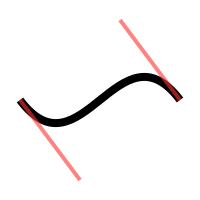

In [6]:
IPython.display.SVG(data=display_image(draw_demo_image, 200, 200).getvalue())

In [7]:
# adapted from https://github.com/RyanMarcus/humanLines/blob/master/index.js

In [8]:
def time_to_point(sx, sy, fx, fy, t):
    # scale the time value, which should be between 0 and 2, to 0 and 1
    tau = t / 2.0;
    poly_term = 15. * math.pow(tau, 4.) \
              - 6. * math.pow(tau, 5.) \
              - 10. * math.pow(tau, 3.);
    
    return {"x": sx + (sx - fx) * poly_term,
            "y": sy + (sy - fy) * poly_term };

In [57]:
def get_squiggle(prev, current, seed=None):
    # find the midpoint
    midpoint = {"x": (prev["x"] + current["x"]) / 2., \
                      "y": (prev["y"] + current["y"]) / 2.};

    # displace by a random value between -5 and 5
    # the paper calls to do this w.r.t. the normal of the line
    # but we'll just do it on the circle.
    if seed is not None:
        random.seed(seed)
    def rng():
        return random.random()
    
    #displacementX = rng() * 10 - 5;
    #displacementY = rng() * 10 - 5;
    displacementX = rng() * 2. - 1.;
    displacementY = rng() * 2. - 1.;
    
    midpoint["x"] += displacementX;
    midpoint["y"] += displacementY;
    
    print(f"{midpoint['x']}, {midpoint['y']}")

    return midpoint;

In [58]:
def draw_natural_line(ctx, sx, sy, fx, fy, seed=None, print_points=False):
    
    dist = math.sqrt(math.pow(sx - fx, 2) + math.pow(sy - fy, 2));
    if dist < 200:
        dt = 0.5
    elif dist < 400:
        dt = 0.3
    else:
        dt = 0.2

    last_point = {"x": sx, "y": sy};
    ctx.set_source_rgba(0.7, 0.7, 0.7, 0.7)
    ctx.new_path()
    ctx.move_to(last_point["x"], last_point["y"])
    
    print(f"last.x = {last_point['x']}, last.y = {last_point['y']}")
    for t in np.linspace(0, 2., int(2. / dt) + 1):
        current_point = time_to_point(sx, sy, fx, fy, t);
        squiggle_control_point = get_squiggle(last_point, current_point, seed=seed);
        #print(f"current.x = {current_point['x']}, current.y = {current_point['y']}")
        #ctx.line_to(current_point["x"], current_point["y"])
        helper_quadratic_to(ctx, squiggle_control_point["x"], squiggle_control_point["y"], current_point["x"], current_point["y"]);

        if print_points:
            print(f"current.x = {current_point['x']}, current.y = {current_point['y']}")
            print(f"squiggle.x = {squiggle_control_point['x']}, squiggle.y = {squiggle_control_point['y']}")
            
        last_point = current_point;

    ctx.stroke()

In [62]:
def draw_natural_rect(ctx, x, y, w, h, seed=None, print_points=False):
    draw_natural_line(ctx, x,     y    , x + w, y    , seed=seed, print_points=print_points)
    draw_natural_line(ctx, x + w, y    , x + w, y + h, seed=seed, print_points=print_points)
    draw_natural_line(ctx, x + w, y + h, x    , y + h, seed=seed, print_points=print_points)
    draw_natural_line(ctx, x    , y + h, x    , y    , seed=seed, print_points=print_points)

In [63]:
def demo_natural_line(ctx):
    a = 10
    w = 160
    ctx.translate(250, 0);
    ctx.scale(-1, 1)
    print_points = True
    #draw_natural_rect(ctx, a, a, w, w, print_points=print_points);
    draw_natural_rect(ctx, a + w/3, a + w/3, w, w, print_points=print_points);

    #draw_natural_rect(ctx, a, a, a + w/3, a + w/3, print_points=print_points);
    #draw_natural_rect(ctx, a, a + w, a + w/3, a + w/3 + w, print_points=print_points);
    #draw_natural_rect(ctx, a + w, a, a + w/3 + w, a + w/3, print_points=print_points);
    #draw_natural_rect(ctx, a + w, a + w, a + w/3 + w, a + w/3 + w, print_points=print_points);

last.x = 63.333333333333336, last.y = 63.333333333333336
63.710917788562675, 63.63646087196838
current.x = 63.333333333333336, current.y = 63.333333333333336
squiggle.x = 63.710917788562675, squiggle.y = 63.63646087196838
71.8383638484705, 63.139756748523205
current.x = 79.89583333333334, current.y = 63.333333333333336
squiggle.x = 71.8383638484705, squiggle.y = 63.139756748523205
110.80311046677676, 63.53977080312023
current.x = 143.33333333333334, current.y = 63.333333333333336
squiggle.x = 110.80311046677676, squiggle.y = 63.53977080312023
175.23340407411376, 63.44976532210949
current.x = 206.77083333333334, current.y = 63.333333333333336
squiggle.x = 175.23340407411376, squiggle.y = 63.44976532210949
215.49958870058484, 63.324221530436866
current.x = 223.33333333333334, current.y = 63.333333333333336
squiggle.x = 215.49958870058484, squiggle.y = 63.324221530436866
last.x = 223.33333333333334, last.y = 63.333333333333336
222.91092517994304, 62.50864764576478
current.x = 223.33333333

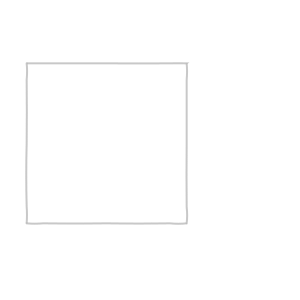

In [64]:
IPython.display.SVG(data=display_image(demo_natural_line, 300, 300).getvalue())